In [18]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
import scipy.signal as signal
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

### Implementing Singular Value Decomposition

In [19]:
def svd(X):
    n, m = X.shape
    X_center = X - np.mean(X, axis=0)
    covariance = np.dot(X_center.T, X_center) / (n-1)
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    singular_values = np.sqrt(eigenvalues)
    U = np.dot(X_center, eigenvectors) / singular_values
    return U, singular_values, eigenvectors.T

### Implementing PCA using SVD

In [20]:
def pca_using_svd(X):
    U, S, V = svd(X)
    Z = np.dot(U, np.diag(S))
    return Z, V.T

### Implementing PCA using covariance matrix and eigen values

In [21]:
def pca_using_covmat(X):
    n, m = X.shape
    X_center = X - np.mean(X, axis=0)
    C = np.dot(X_center.T, X_center) / (n - 1)
    eigen_values, eigen_vectors = np.linalg.eig(C)
    eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(m)]
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)
    W = np.hstack([eigen_pairs[i][1].reshape(m, 1) for i in range(m)])
    Z = np.dot(X_center, W)
    return Z, W

In [22]:
def plot_components(Z, t):
    n, m = Z.shape
    plt.figure(figsize=(20, 10))
    for i in range(m):
        plt.plot(t, Z[:, i], label=f'Component {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# PART - A

#### Generating Signals

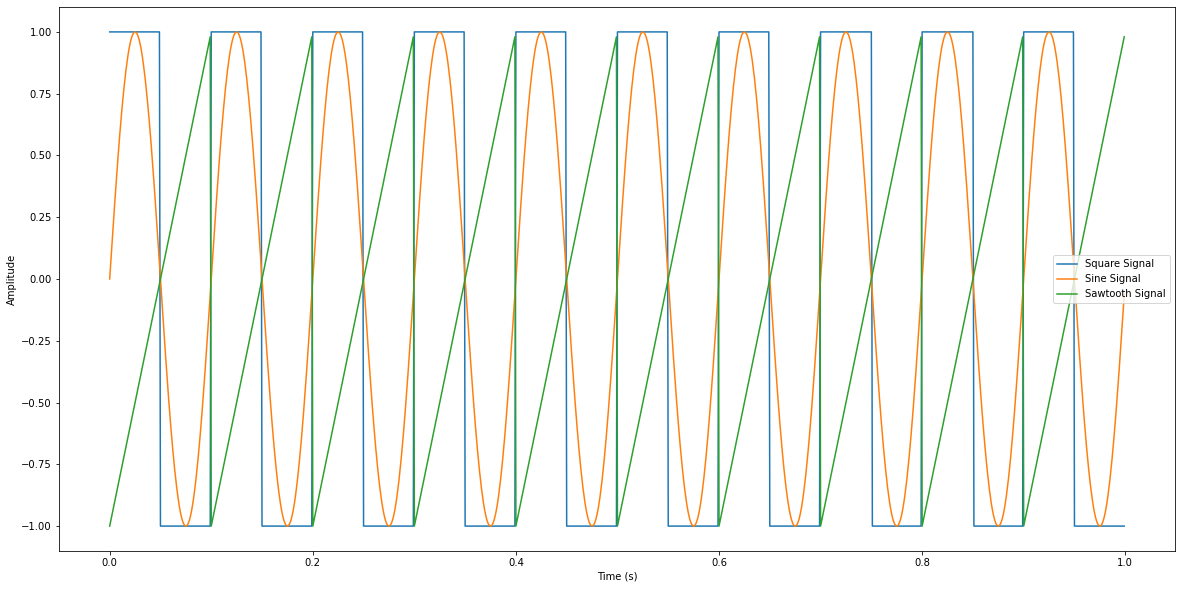

In [50]:
fs = 1000
t = np.arange(0,1, 1/fs)

square_signal = signal.square(2 * np.pi * 10 * t)
sine_signal = np.sin(2 * np.pi * 10 * t)
sawtooth_signal = signal.sawtooth(2 * np.pi * 10 * t)

plt.figure(figsize=(20, 10))
plt.plot(t, square_signal, label='Square Signal')
plt.plot(t, sine_signal, label='Sine Signal')
plt.plot(t, sawtooth_signal, label='Sawtooth Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

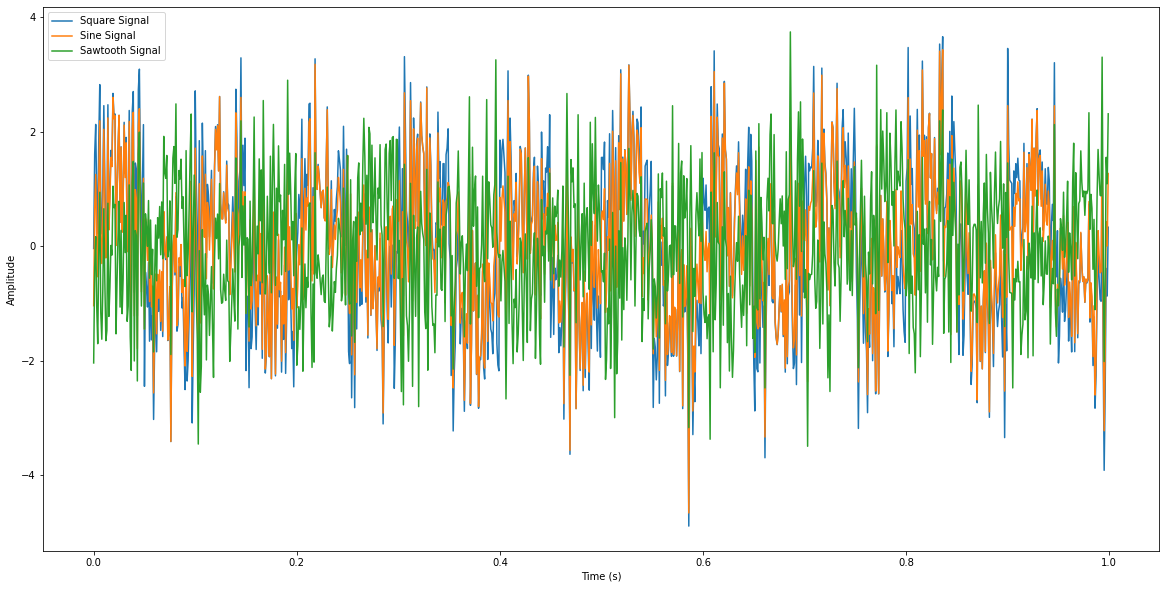

In [51]:
num_samples = len(t)
noise = np.random.normal(0, 1, size=num_samples)
# Adding noise to the sine signal
sine_signal_noise = sine_signal + noise
# Adding noise to the square signal
square_signal_noise = square_signal + noise
# Adding noise to the sawtooth signal
sawtooth_signal_noise = sawtooth_signal + noise

#ploting the signals
plt.figure(figsize=(20, 10))
plt.plot(t, square_signal_noise, label='Square Signal')
plt.plot(t, sine_signal_noise, label='Sine Signal')
plt.plot(t, sawtooth_signal_noise, label='Sawtooth Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

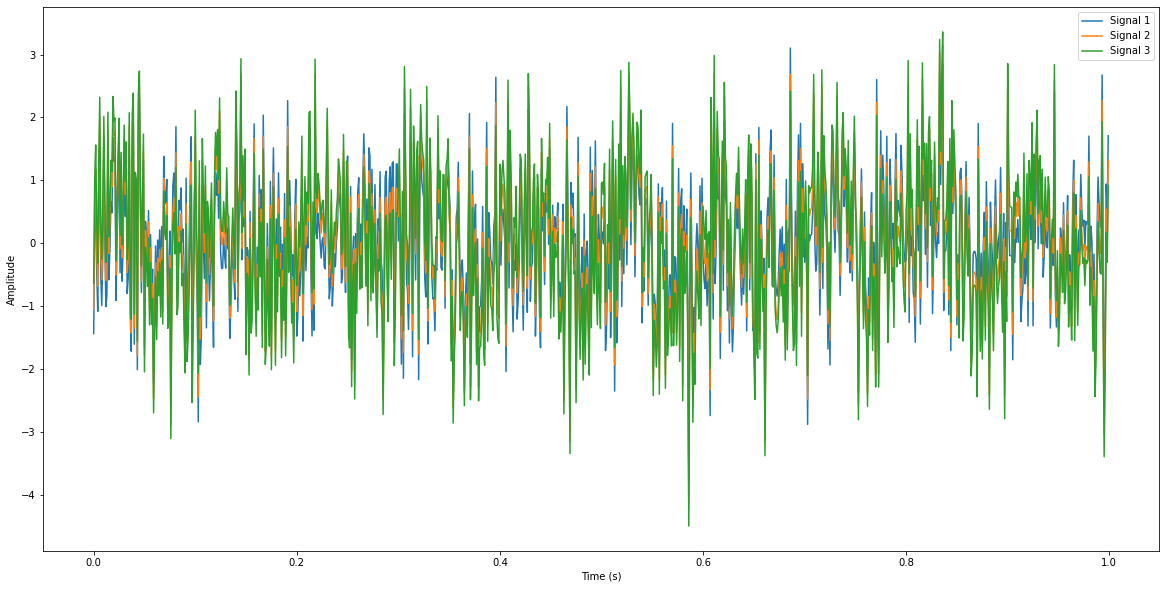

In [52]:
signal1 = 0.2*square_signal_noise + 0.2*sine_signal_noise + 0.6*sawtooth_signal_noise
signal2 = 0.33*square_signal_noise + 0.33*sine_signal_noise + 0.34*sawtooth_signal_noise
signal3 = 0.6*square_signal_noise + 0.2*sine_signal_noise + 0.2*sawtooth_signal_noise

# Ploting the signals
plt.figure(figsize=(20, 10))
plt.plot(t, signal1, label='Signal 1')
plt.plot(t, signal2, label='Signal 2')
plt.plot(t, signal3, label='Signal 3')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


#### Applying PCA on signals

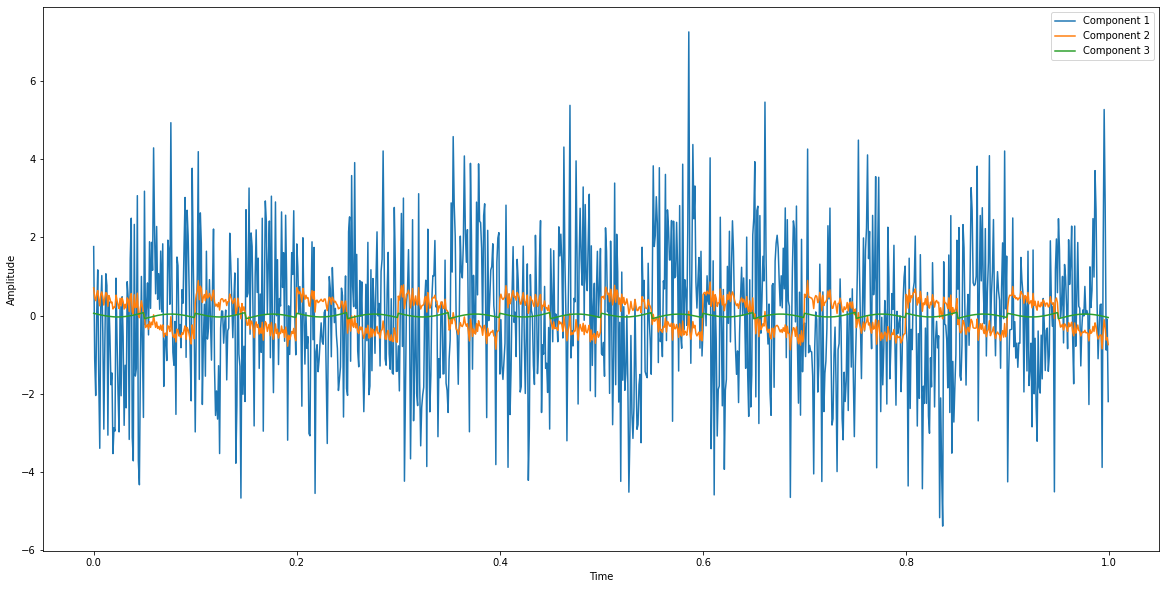

In [53]:
signals = np.column_stack([signal1, signal2, signal3])
Z, W = pca_using_covmat(signals)
plot_components(Z,t)

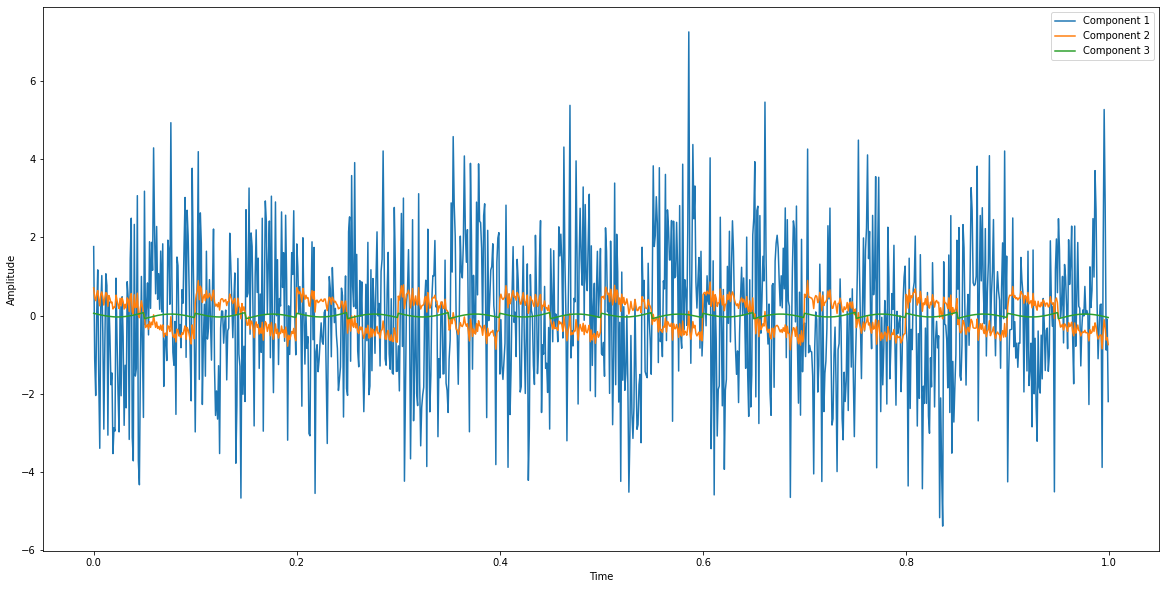

In [54]:
signals = np.column_stack([signal1, signal2, signal3])
Z, W = pca_using_svd(signals)
plot_components(Z,t)

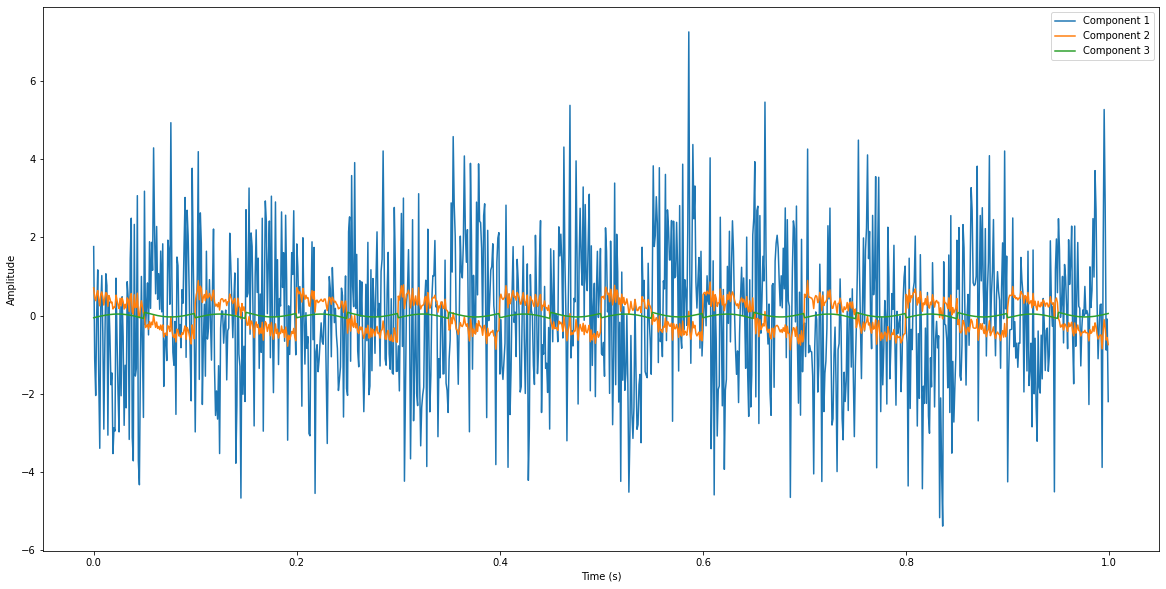

In [55]:
pca = PCA(n_components=3)
S_ = pca.fit_transform(np.array([signal1, signal2, signal3]).T)  # Reconstruct signals
A_ = pca.components_  # Get estimated mixing matrix

plt.figure(figsize=(20, 10))
plt.plot(t, S_[:,0], label='Component 1')
plt.plot(t, S_[:,1], label='Component 2')
plt.plot(t, S_[:,2], label='Component 3')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### Applying ICA on signals

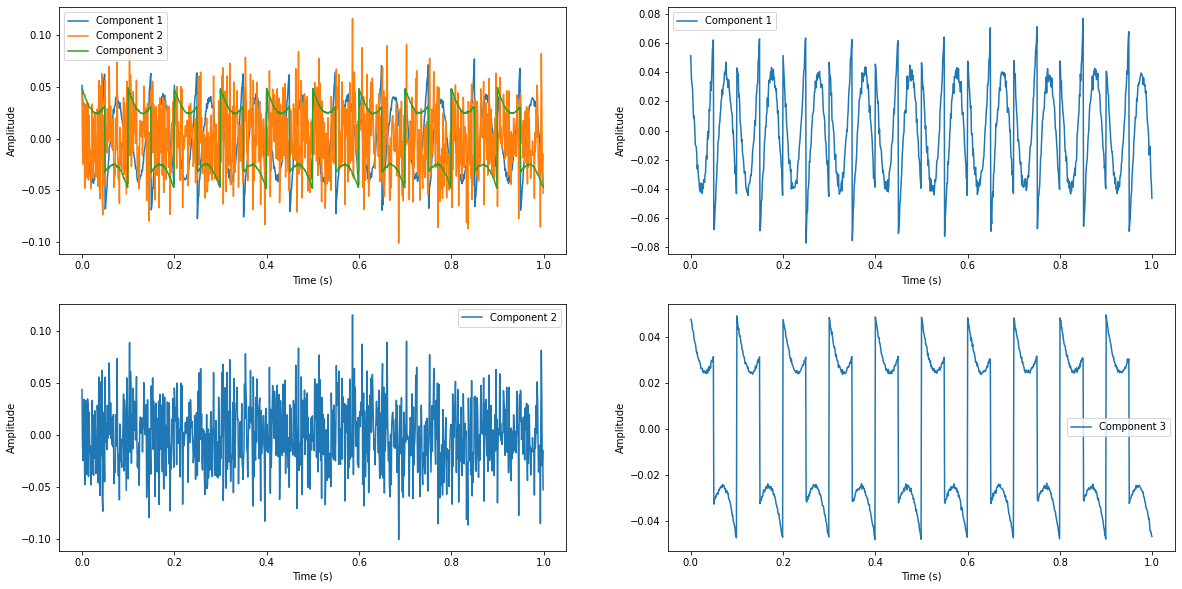

In [56]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(np.array([signal1, signal2, signal3]).T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

f,ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(t, S_[:,0], label='Component 1')
ax[0,0].plot(t, S_[:,1], label='Component 2')
ax[0,0].plot(t, S_[:,2], label='Component 3')
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].legend()
ax[0,1].plot(t, S_[:,0], label='Component 1')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].legend()
ax[1,0].plot(t, S_[:,1], label='Component 2')
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].legend()
ax[1,1].plot(t, S_[:,2], label='Component 3')
ax[1,1].set_xlabel('Time (s)')
ax[1,1].set_ylabel('Amplitude')
ax[1,1].legend()

# plt.figure(figsize=(20, 10))
# plt.plot(t, S_[:,2], label='Signal 3')
# plt.plot(t, S_[:,0], label='Signal 1')
# plt.plot(t, S_[:,1], label='Signal 2')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.legend()   
# plt.show()


### For the mixture of these signals the PCA looks better than ICA. In PCA we can clearly distinguish sine wave, sawtooth wave and sqaure wave. Probably this is because the signals used have somewhat linear structure with some correlation and they are not statistically independent.

# PART - B

This is a sample dataset provided by MNE. 
- In this experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.
- EEG data from a 60-channel electrode cap was acquired simultaneously with the MEG
- For first part we are using only EEG data ( along with EOG and ECG channels recorded)
- The second part has code to work with MEG data

Link to the description - https://mne.tools/stable/overview/datasets_index.html#sample

In [30]:
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.Raw(raw_fname)
raw.info

Opening raw data file C:\Users\91626\mne_data\MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>

# EEG

---


# **Plot the RAW data and view**  (EDITME)
Change the duration and the number of channels and browse through the data

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


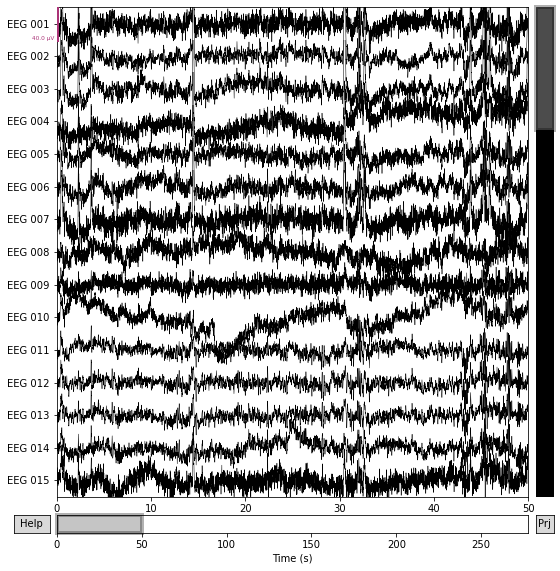

In [31]:
raw_eeg = raw.copy()
raw_eeg.pick_types(meg=False, eeg=True, eog=True, ecg=True) # Selecting EEG, EOG and ECG channels <======
x = raw_eeg.plot(duration=50,n_channels=15) # Tweak duration & number of channels <======



---


# Run ICA  - plot components and browse
Try to edit the number of components and re-run the ICA

- https://mne.tools/stable/generated/mne.preprocessing.ICA.html

In [32]:
ica_eeg = ICA(n_components=15, random_state=97) #Setup ICA <=======
ica_eeg.fit(raw_eeg) # Run ICA

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.0s.


<ICA | raw data decomposition, method: fastica (fit in 32 iterations on 41700 samples), 15 ICA components (59 PCA components available), channel types: eeg, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=16, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


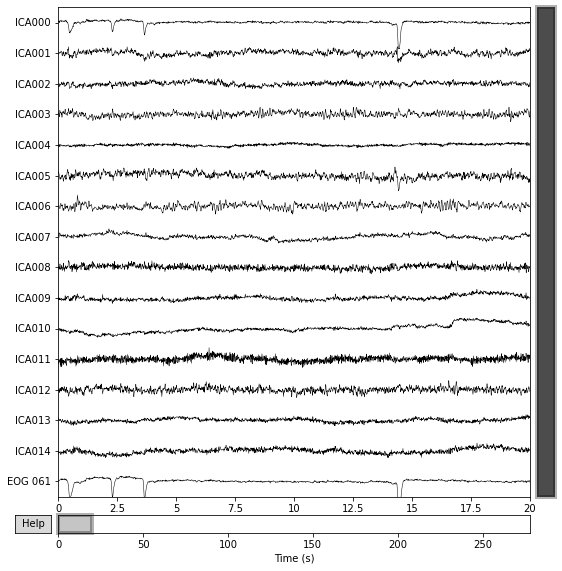

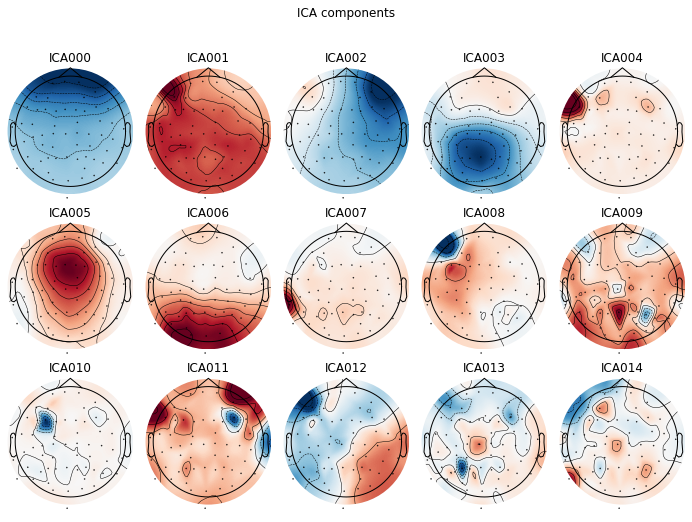

In [33]:
x = ica_eeg.plot_sources(raw_eeg) # Plot time series
x = ica_eeg.plot_components() #Plot topographies

# Drop artefactual components (EDITME)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 59 PCA components


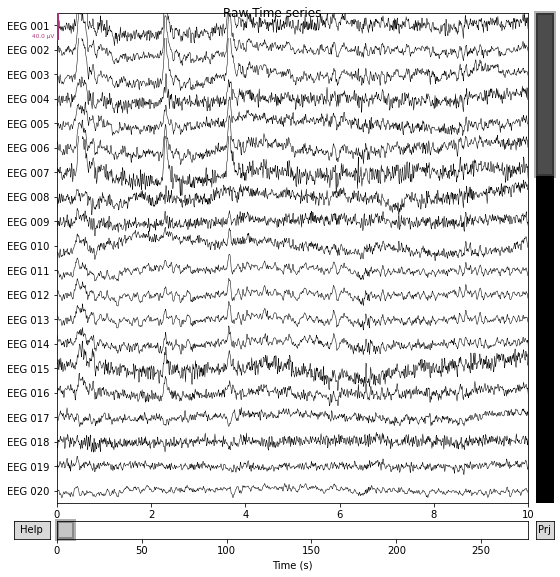

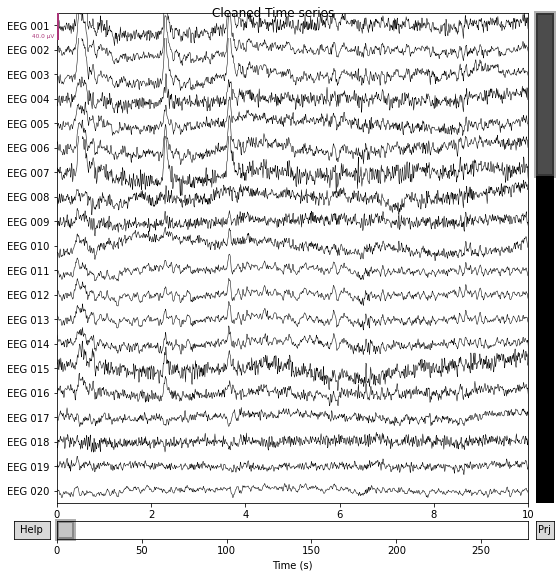

In [34]:
raw_eeg.load_data()

ica_eeg.exclude = []  # indices chosen based on various plots above <======

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw_eeg.copy()
ica_eeg.apply(reconst_raw)

#Raw
raw_eeg.plot(show=False)
plt.suptitle('Raw Time series')


#Reconstruced after removing artefactual components
reconst_raw.plot(show=False)
plt.suptitle('Cleaned Time series')
plt.show()
del reconst_raw


# MEG 
---  
# **Plot the RAW data and view**  
Change the duration and the number of channels and browse through the data

Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>


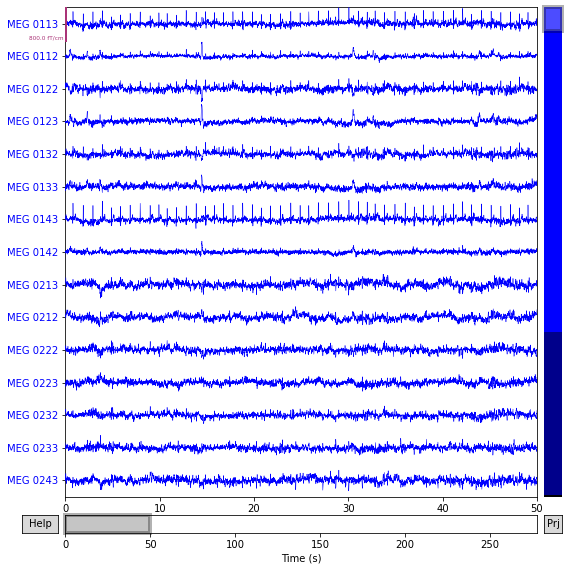

In [35]:
raw_meg = raw.copy()
raw_meg.pick_types(meg=True, eeg=False, eog=True, ecg=True) # Selecting MEG, EOG and ECG channels <======
x = raw_meg.plot(duration=50,n_channels=15) # Tweak duration & number of channels <======

In [36]:
ica_meg = ICA(n_components=15, random_state=97) #Setup ICA <=======
ica_meg.fit(raw_meg) # Run ICA

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.5s.


<ICA | raw data decomposition, method: fastica (fit in 37 iterations on 41700 samples), 15 ICA components (305 PCA components available), channel types: mag, grad, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=16, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


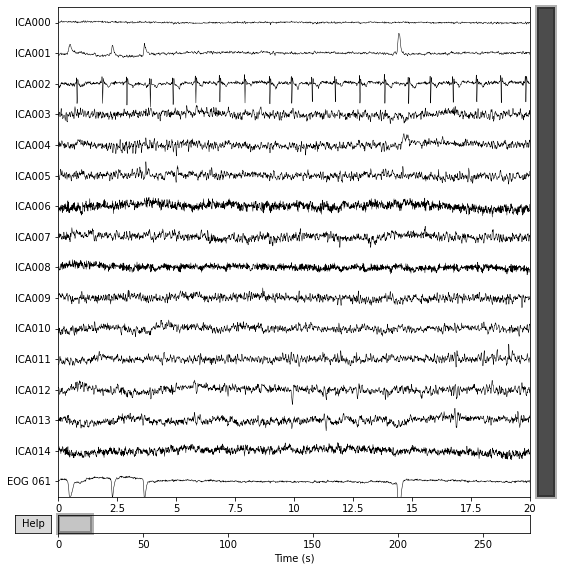

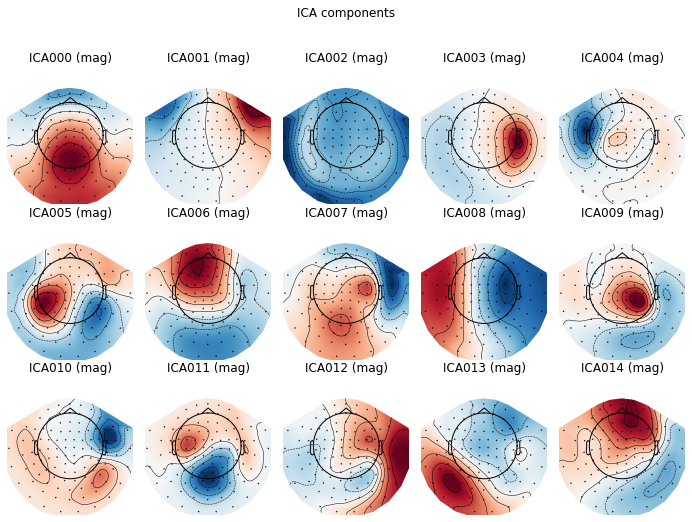

In [37]:
x = ica_meg.plot_sources(raw_meg) # Plot time series
x = ica_meg.plot_components() #Plot topographies

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 305 PCA components


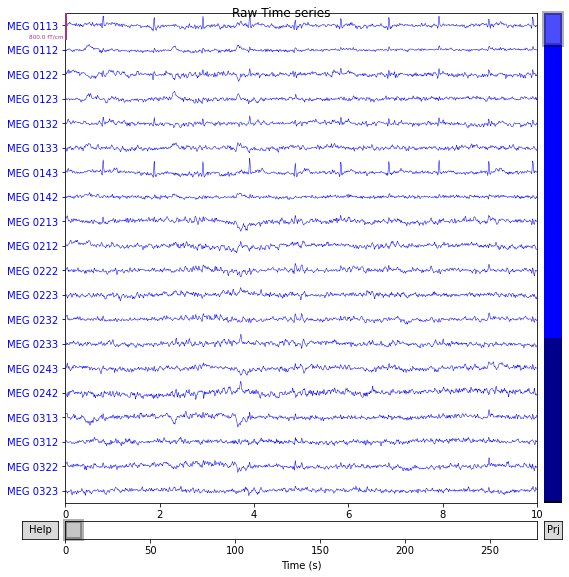

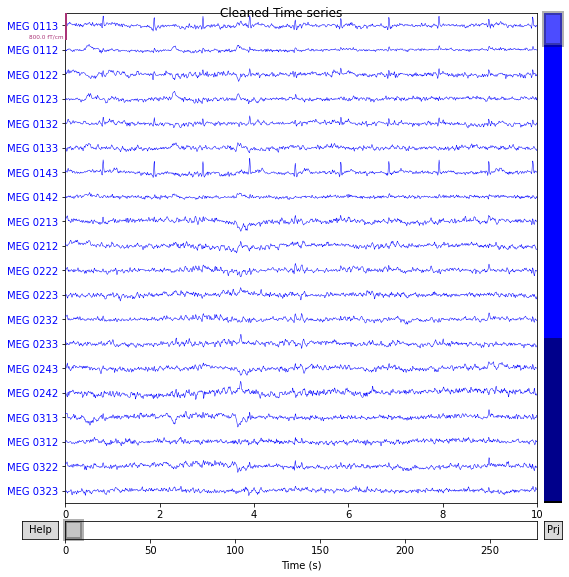

In [38]:
raw_meg.load_data()

ica_meg.exclude = []  # indices chosen based on various plots above <======

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw_meg.copy()
ica_meg.apply(reconst_raw)

#Raw
raw_meg.plot(show=False)
plt.suptitle('Raw Time series')


#Reconstruced after removing artefactual components
reconst_raw.plot(show=False)
plt.suptitle('Cleaned Time series')
plt.show()
del reconst_raw